# This notebook is just here to allow me to generate images for the report

In [1]:
# Packages
%matplotlib inline

import argparse
import gc
import os.path

import pandas as pd
from torch.linalg import LinAlgError

import matplotlib.pyplot as plt
import torchvision
import torch
from torch import optim

from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import datetime

import random
import numpy as np

import sys
import os
# add the path to find colour_mnist
sys.path.append(os.path.abspath('../ReferenceCode'))
import colour_mnist
from stitch_utils import train_model, RcvResNet18, StitchedResNet18, get_layer_output_shape
from stitch_utils import generate_activations, SyntheticDataset
import stitch_utils

# add the path to find the rank analysis code
# https://github.com/DHLSmith/jons-tunnel-effect/tree/NeurIPSPaper
sys.path.append(os.path.abspath('../../jons-tunnel-effect/'))
from utils.modelfitting import evaluate_model, set_seed
from extract_weight_rank import install_hooks, perform_analysis

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# To track memory usage
import psutil
process = psutil.Process()
            

def logtofile(log_text, verbose=True):
    if verbose:
        print(log_text)
    with open(save_log_as, "a") as f:    
        print(log_text, file=f)

In [2]:
# Set Parameters

# fix random seed for reproducibility
seed = 0
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
random.seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

bg_noise = 0.0

batch_size = 128
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
colour_mnist_shape = (3,28,28)

mnist and cifar-10 both use 10-classes, with 60_000 train samples and 10_000 test samples. 

In [3]:
# Set up dataloaders
transform_bw = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels    
    transforms.ToTensor(),  # convert to tensor. We always do this one    
    transforms.Normalize((0.1307,) * 3, (0.3081,) * 3)     
])

mnist_train = MNIST("./MNIST", train=True, download=True, transform=transform_bw)
mnist_test = MNIST("./MNIST", train=False, download=True, transform=transform_bw)

bw_train_dataloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
bw_test_dataloader  = DataLoader(mnist_test,  batch_size=batch_size, shuffle=True, drop_last=False)

# mix dataloader
mix_train_dataloader = colour_mnist.get_mixed_mnist_dataloader(root="./MNIST", batch_size=batch_size, train=True, bg_noise_level=bg_noise, standard_getitem=True)
mix_test_dataloader = colour_mnist.get_mixed_mnist_dataloader(root="./MNIST", batch_size=batch_size,  train=False, bg_noise_level=bg_noise, standard_getitem=True)

# bg_only means no digits - we will use colour as label
bg_only_train_dataloader = colour_mnist.get_biased_mnist_dataloader(root="./MNIST", batch_size=batch_size, data_label_correlation=1.0, train=True, bg_noise_level=bg_noise, bg_only=True, standard_getitem=True)
bg_only_test_dataloader = colour_mnist.get_biased_mnist_dataloader(root="./MNIST", batch_size=batch_size, data_label_correlation=1.0, train=False, bg_noise_level=bg_noise, bg_only=True, standard_getitem=True)

# unbiased means each digit has correct label and random colour - but bg means we will use colour as label (i.e. the bias_target will be the target)
bg_unbiased_train_dataloader = colour_mnist.get_biased_mnist_dataloader(root="./MNIST", batch_size=batch_size, data_label_correlation=0.1, train=True, bg_noise_level=bg_noise, bias_targets_as_targets=True)
bg_unbiased_test_dataloader = colour_mnist.get_biased_mnist_dataloader(root="./MNIST", batch_size=batch_size, data_label_correlation=0.1, train=False, bg_noise_level=bg_noise, bias_targets_as_targets=True)

# biased means each digit has correct label and consistent colour - Expect network to learn the colours only
biased_train_dataloader = colour_mnist.get_biased_mnist_dataloader(root="./MNIST", batch_size=batch_size, data_label_correlation=1.0, train=True, bg_noise_level=bg_noise, standard_getitem=True)
biased_test_dataloader = colour_mnist.get_biased_mnist_dataloader(root="./MNIST", batch_size=batch_size, data_label_correlation=1.0, train=False, bg_noise_level=bg_noise, standard_getitem=True)

# unbiased means each digit has correct label and random colour - Expect network to disregard colours?
unbiased_train_dataloader = colour_mnist.get_biased_mnist_dataloader(root="./MNIST", batch_size=batch_size, data_label_correlation=0.1, train=True, bg_noise_level=bg_noise, standard_getitem=True)
unbiased_test_dataloader = colour_mnist.get_biased_mnist_dataloader(root="./MNIST", batch_size=batch_size, data_label_correlation=0.1, train=False, bg_noise_level=bg_noise, standard_getitem=True)

## Set up resnet18 models and train it on versions of MNIST

In [4]:

process_structure = dict()
device = 'cuda:0'


#process_structure["bw"] = dict()
process_structure["bias"]      = dict()
process_structure["unbias"]    = dict()
process_structure["bg"] = dict()
process_structure["bgonly"] = dict()
#process_structure["mix"] = dict()

# "mix"
#process_structure["mix"]["model"] = torchvision.models.resnet18(num_classes=10).to(device) # Untrained model
#process_structure["mix"]["train"] = train_mix_mnist_model 
#process_structure["mix"]["train_loader"] = mix_train_dataloader
#process_structure["mix"]["test_loader"] = mix_test_dataloader
#process_structure["mix"]["saveas"] = save_mix_mnist_model_as
#process_structure["mix"]["loadfrom"] = mix_mnist_model_to_load
#
## "bw"
#process_structure["bw"]["model"] = torchvision.models.resnet18(num_classes=10).to(device) # Untrained model
#process_structure["bw"]["train"] = train_bw_mnist_model 
#process_structure["bw"]["train_loader"] = bw_train_dataloader
#process_structure["bw"]["test_loader"] = bw_test_dataloader
#process_structure["bw"]["saveas"] = save_bw_mnist_model_as
#process_structure["bw"]["loadfrom"] = bw_mnist_model_to_load
#
# "bg_only_colour"
#process_structure["bgonly"]["model"] = torchvision.models.resnet18(num_classes=10).to(device) # Untrained model
#process_structure["bgonly"]["train"] = train_bg_only_colour_mnist_model 
process_structure["bgonly"]["train_loader"] = bg_only_train_dataloader
#process_structure["bgonly"]["test_loader"] = bg_only_test_dataloader
#process_structure["bgonly"]["saveas"] = save_bg_only_colour_mnist_model_as
#process_structure["bgonly"]["loadfrom"] = bg_only_colour_mnist_model_to_load
#
## "bg_unbiased_colour"
#process_structure["bg"]["model"] = torchvision.models.resnet18(num_classes=10).to(device) # Untrained model
#process_structure["bg"]["train"] = train_bg_unbiased_colour_mnist_model 
process_structure["bg"]["train_loader"] = bg_unbiased_train_dataloader
#process_structure["bg"]["test_loader"] = bg_unbiased_test_dataloader
#process_structure["bg"]["saveas"] = save_bg_unbiased_colour_mnist_model_as
#process_structure["bg"]["loadfrom"] = bg_unbiased_colour_mnist_model_to_load
#
## "biased_colour_mnist"
#process_structure["bias"]["model"] = torchvision.models.resnet18(num_classes=10).to(device) # Untrained model
#process_structure["bias"]["train"] = train_biased_colour_mnist_model
process_structure["bias"]["train_loader"] = biased_train_dataloader
#process_structure["bias"]["test_loader"] = biased_test_dataloader
#process_structure["bias"]["saveas"] = save_biased_colour_mnist_model_as
#process_structure["bias"]["loadfrom"] =  biased_colour_mnist_model_to_load
#
## "unbiased_colour_mnist"
#process_structure["unbias"]["model"] = torchvision.models.resnet18(num_classes=10).to(device) # Untrained model
#process_structure["unbias"]["train"] = train_unbiased_colour_mnist_model
process_structure["unbias"]["train_loader"] = unbiased_train_dataloader
#process_structure["unbias"]["test_loader"] = unbiased_test_dataloader
#process_structure["unbias"]["saveas"] = save_unbiased_colour_mnist_model_as
#process_structure["unbias"]["loadfrom"] =  unbiased_colour_mnist_model_to_load


## For each dataloader, get 2 images each with label 0, 1


first pixel of image 0,0 is [1.         0.50196081 0.        ]
first pixel of image 0,2 is [1.         0.         0.50196081]
['bias', 'unbias', 'bg', 'bgonly']
['Corr.', 'Digit', 'Colour', 'Colour\nOnly']
(4, 6)
len(image_data)=4
(4, 6, 28, 28, 3)
len(image_labels)=6


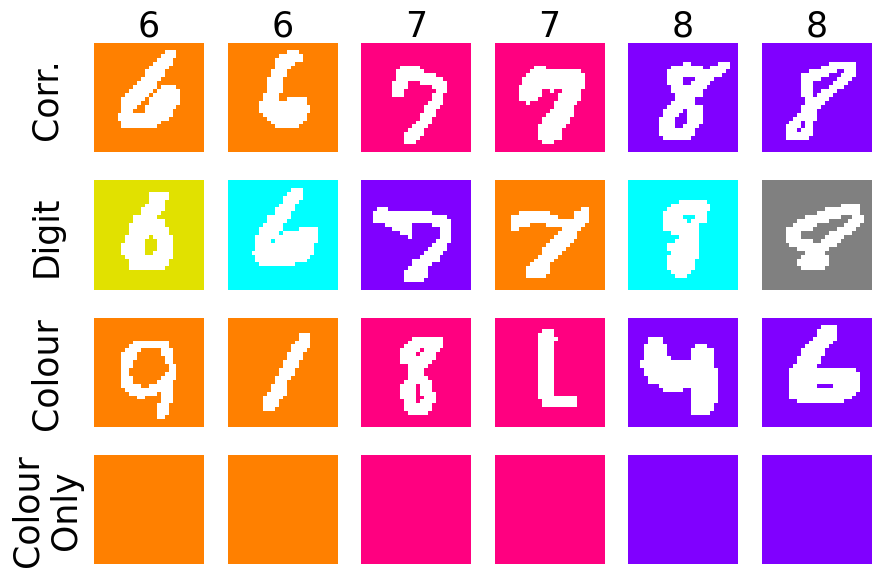

In [7]:
image_labels = [6,6,7,7,8,8] # chosen to be better for colour-blindness
image_data = np.random.rand(len(process_structure), len(image_labels), 28, 28, 3)  

row_labels = []
row = 0
'''
for key, val in process_structure.items():
    col = 0
    TDL = val["train_loader"]  
    train_iterator = iter(TDL)
    train_batch = next(train_iterator)
    
    row_labels.append(key)
    for j in range(len(train_batch[0])):
        if train_batch[1][j] == image_labels[col]:
            plt.imshow(train_batch[0][j].permute(1,2,0))
            plt.axis("off")
            plt.savefig(f"./results/cmi_{key}_{image_labels[col]}_[{row},{col}].png", bbox_inches='tight')
            plt.show()
            # cmi = colour mnist image
            image_data[row][col]=train_batch[0][j].permute(1,2,0)            
            col += 1
            if col == len(image_labels):
                break
    row += 1
'''
for key, val in process_structure.items():
    col = 0
    TDL = val["train_loader"]  
    train_iterator = iter(TDL)
    train_batch = next(train_iterator)
    row_labels.append(key)
    for j in range(len(train_batch[0])):
        if train_batch[1][j] == image_labels[col]:
            #plt.imshow(train_batch[0][j].permute(1,2,0))
            #plt.axis("off")
            #plt.savefig(f"./results/cmi_{key}_{image_labels[col]}_[{row},{col}].png", bbox_inches='tight')
            #plt.show()
            # cmi = colour mnist image
            image_data[row][col]=(train_batch[0][j].permute(1,2,0) + 1 ) / 2  # rescale for imshow
            col += 1
            if col == len(image_labels):
                break
    row += 1

print(f"first pixel of image 0,0 is {image_data[0,0][0,0]}")
print(f"first pixel of image 0,2 is {image_data[0,2][0,0]}")

print(row_labels)
row_labels = ["Corr.", "Digit", "Colour", "Colour\nOnly"]
print(row_labels)

fig, axes = plt.subplots(len(row_labels), len(image_labels), figsize=(9, 5.9))
print(axes.shape)
print(f'{len(image_data)=}')
print(image_data.shape)
print(f'{len(image_labels)=}')
# Loop through each row and each column
for i in range(len(image_data)):
    for j in range(len(image_labels)):
        ax = axes[i, j]
        ax.imshow(image_data[i, j]) 
        ax.axis('off')  # Hide axes ticks

        # Label columns with horizontal text at the top
        if i == 0:
            ax.set_title(image_labels[j], fontsize=25, pad=0)

    # Label rows with vertical text on the left
    axes[i, 0].annotate(row_labels[i], xy=(0, 0.5), xytext=(-axes[i, 0].yaxis.labelpad - 30, 0),
                        xycoords='axes fraction', textcoords='offset points',
                        ha='center', va='center', rotation='vertical', fontsize=25)

plt.tight_layout(pad=1.0)
#plt.savefig("./results/cmi_sampler.png", bbox_inches='tight')
plt.savefig("./results/cmi_sampler.pdf", bbox_inches='tight')
plt.show()


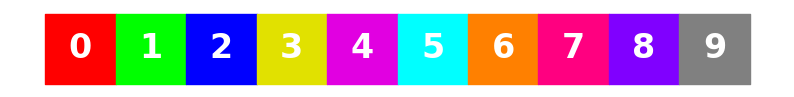

In [6]:
import matplotlib.pyplot as plt

# Define the RGB values
colour_map =[[255, 0, 0], [0, 255, 0], [0, 0, 255], [225, 225, 0],
[225, 0, 225], [0, 255, 255], [255, 128, 0], [255, 0, 128],
[128, 0, 255], [128, 128, 128]]    

# Convert RGB values from 0-255 range to 0-1 range for matplotlib
colours_normalized = [[r/255, g/255, b/255] for r, g, b in colour_map]

# Create the plot
plt.figure(figsize=(10, 1))
for i, colour in enumerate(colours_normalized):
    plt.fill_between([i, i+1], 0, 1, color=colour)
    plt.text(i + 0.5, 0.5, str(i), color='white', fontsize=24, fontweight='bold', ha='center', va='center' )

plt.gca().axis('off') # I don't want ticks or a border

# Display and save the color swatches
plt.savefig("./results/colour_swatches.png", bbox_inches='tight')
plt.savefig("./results/colour_swatches.pdf", bbox_inches='tight')
plt.show()

get_layer_output_shape for type='ResNet18'
representation_shape=torch.Size([64, 7, 7])


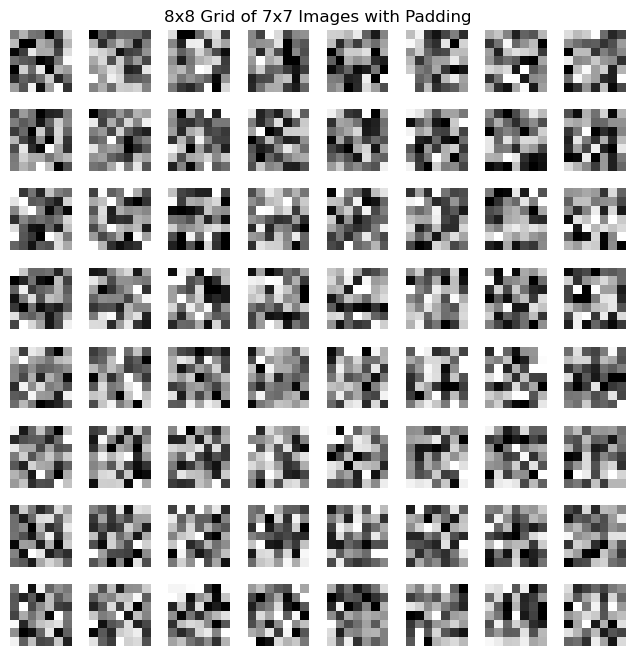

In [87]:
# Try to plot "random noise" 
# fix random seed for reproducibility
from stitch_utils import train_model, RcvResNet18, get_layer_output_shape
from stitch_utils import generate_activations, SyntheticDataset
import stitch_utils
seed = 1
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
random.seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
layer_to_cut_after = 3
colour_mnist_shape = (3,28,28)
device = "cpu"
model = torchvision.models.resnet18(num_classes=10).to(device)
# model.load_state_dict(torch.load(filename, map_location=torch.device(device)))  # uses either the load/save name depending whether it'
cut_layer_output_size = get_layer_output_shape(model, layer_to_cut_after, colour_mnist_shape, device)

representation_shape=(cut_layer_output_size[1:])
print(f"{representation_shape=}")        
syn_activations = generate_activations(num_classes=10, representation_shape=representation_shape)
        
syn_test_set  = SyntheticDataset(train=False, activations=syn_activations, noise=0.1)
TDL  = DataLoader(syn_test_set, batch_size=1, shuffle=False, drop_last=False)     

train_iterator = iter(TDL)
train_batch = next(train_iterator)

# Create a sample tensor of shape [64, 7, 7]
tensor = train_batch[0][0]

# Define grid and padding parameters
grid_size = 8  # 8x8 grid
image_size = 7  # Each image is 7x7 pixels
padding = 2  # Padding size (in pixels)

# Calculate the size of the padded grid
padded_image_size = image_size + padding
grid_image_size = grid_size * padded_image_size - padding

# Create an empty grid tensor filled with zeros (for padding)
grid_tensor = torch.ones(grid_image_size, grid_image_size)

# Fill the grid with 7x7 images and add padding
for row in range(grid_size):
    for col in range(grid_size):
        start_row = row * padded_image_size
        start_col = col * padded_image_size
        grid_tensor[start_row:start_row + image_size, start_col:start_col + image_size] = tensor[row * grid_size + col]

# Convert to NumPy for visualization
grid_numpy = grid_tensor.numpy()

# Display the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid_numpy, cmap='gray', vmin=0, vmax=1)  # Use 'gray' colormap for [0, 1] range
plt.axis('off')  # Hide axis for clarity
plt.title("8x8 Grid of 7x7 Images with Padding")
plt.show()
